In [125]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import TraceDict
from einops import rearrange, einsum
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
from datasets import Dataset
from torch.utils.data import DataLoader, SequentialSampler
import analysis_utils
# from model_aligner_script import load_data
from counterfactual_datasets.entity_tracking import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = "./llama_7b"
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path).to(DEVICE)
tokenizer.pad_token_id = tokenizer.eos_token_id

model.eval()
for param in model.parameters():
    param.requires_grad_(False)

Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.26s/it]


In [3]:
NUM_HEADS = model.config.num_attention_heads
HEAD_SIZE = model.config.hidden_size // NUM_HEADS

## Desiderata

In [137]:
def load_data(raw_data, batch_size):
    train_size = int(0.8 * len(raw_data[0]))
    eval_size = int(0.2 * len(raw_data[0]))

    print("Train size: ", train_size)
    print("Eval size: ", eval_size)
    print("Test size: ", len(raw_data[0]) - train_size - eval_size)

    raw_train = (
        raw_data[0][:train_size],
        raw_data[1][:train_size],
        raw_data[2][:train_size],
        raw_data[3][:train_size],
        raw_data[4][:train_size],
    )
    raw_eval = (
        raw_data[0][train_size : train_size + eval_size],
        raw_data[1][train_size : train_size + eval_size],
        raw_data[2][train_size : train_size + eval_size],
        raw_data[3][train_size : train_size + eval_size],
        raw_data[4][train_size : train_size + eval_size],
    )
    raw_test = (
        raw_data[0][train_size + eval_size :],
        raw_data[1][train_size + eval_size :],
        raw_data[2][train_size + eval_size :],
        raw_data[3][train_size + eval_size :],
        raw_data[4][train_size + eval_size :],
    )

    train_dataset = Dataset.from_dict(
        {
            "base_input_ids": raw_train[0],
            "base_input_last_pos": raw_train[1],
            "source_input_ids": raw_train[2],
            "source_input_last_pos": raw_train[3],
            "labels": raw_train[4],
        }
    ).with_format("torch")
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
    )

    eval_dataset = Dataset.from_dict(
        {
            "base_input_ids": raw_eval[0],
            "base_input_last_pos": raw_eval[1],
            "source_input_ids": raw_eval[2],
            "source_input_last_pos": raw_eval[3],
            "labels": raw_eval[4],
        }
    ).with_format("torch")
    eval_dataloader = DataLoader(
        eval_dataset,
        batch_size=batch_size,
    )

    test_dataset = Dataset.from_dict(
        {
            "base_input_ids": raw_test[0],
            "base_input_last_pos": raw_test[1],
            "source_input_ids": raw_test[2],
            "source_input_last_pos": raw_test[3],
            "labels": raw_test[4],
        }
    ).with_format("torch")
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
    )

    return train_dataloader, eval_dataloader, test_dataloader

In [139]:
data_file_path = "./box_datasets/no_instructions/original/Random/3/train.jsonl"
object_file_path = "./box_datasets/objects_with_bnc_frequency.csv"

raw_data = box_label_value_fetcher_desiderata(
    tokenizer=tokenizer,
    num_samples=500,
    data_file=data_file_path,
    object_file=object_file_path,
    num_boxes=3,
)

In [140]:
objValueFetcher_train, objValueFetcher_eval, objValueFetcher_test = load_data(
    raw_data=raw_data, batch_size=40
)

Train size:  400
Eval size:  100
Test size:  0


In [141]:
desiderata_train = [objValueFetcher_train]
desiderata_eval = [objValueFetcher_eval]
desiderata_valid = [objValueFetcher_test]

In [142]:
data = next(enumerate(desiderata_train[0]))[1]
bi = 1
print(tokenizer.decode(data["base_input_ids"][bi][: data["base_input_last_pos"][bi] + 1]))
print(tokenizer.decode(data["source_input_ids"][bi][: data["source_input_last_pos"][bi] + 1]))
print(tokenizer.decode(data["labels"][bi]))

 Box X contains the television, Box T contains the bell, Box A contains the machine. Box T contains the
 Box X contains the spatula, Box T contains the camera, Box A contains the fish. The Box A contains
 machine


## Training Binary Mask

In [153]:
modules = [f"model.layers.{i}.self_attn.o_proj" for i in range(32)]

In [154]:
from_activations_train = {}

for di, desid_train in enumerate(desiderata_train):
    from_activations_train[di] = {}

    for bi, inputs in enumerate(desid_train):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(DEVICE)

        from_activations_train[di][bi] = {}
        with torch.no_grad():
            with TraceDict(model, modules, retain_input=True) as trace:
                _ = model(inputs["source_input_ids"])

                for module in modules:
                    if "self_attn" in module:
                        from_activations_train[di][bi][module] = trace[module].input.detach().cpu()
                    else:
                        from_activations_train[di][bi][module] = trace[module].output.detach().cpu()

        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cpu")

        del trace
        torch.cuda.empty_cache()

In [155]:
from_activations_eval = {}

for di, desid_eval in enumerate(desiderata_eval):
    from_activations_eval[di] = {}

    for bi, inputs in enumerate(desid_eval):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(DEVICE)

        from_activations_eval[di][bi] = {}
        with torch.no_grad():
            with TraceDict(model, modules, retain_input=True) as trace:
                _ = model(inputs["source_input_ids"])

                for module in modules:
                    if "self_attn" in module:
                        from_activations_eval[di][bi][module] = trace[module].input.detach().cpu()
                    else:
                        from_activations_eval[di][bi][module] = trace[module].output.detach().cpu()

        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cpu")

        del trace
        torch.cuda.empty_cache()

In [156]:
modules_w_heads = []
for module in modules:
    if "self_attn" in module:
        for head in range(32):
            modules_w_heads.append(f"{module}.{head}")
    else:
        modules_w_heads.append(module)

mask_dict = {module: i for i, module in enumerate(modules_w_heads)}

In [157]:
def edit_output(
    inputs=None,
    output=None,
    layer=None,
    mask=None,
    from_activations=None,
    to_last_token_pos=None,
    from_last_token_pos=None,
    rel_pos=None,
):
    if "self_attn" in layer:
        inp = inputs[0]
        from_activations[layer] = from_activations[layer].to(DEVICE)

        # Computing the output of each head in this layer after the intervention
        for head_idx in range(NUM_HEADS):
            head_start = head_idx * HEAD_SIZE
            head_end = (head_idx + 1) * HEAD_SIZE
            abl_amt = mask[mask_dict[f"{layer}.{head_idx}"]]

            for bi in range(inp.shape[0]):
                intervention = (
                    abl_amt * inp[bi, to_last_token_pos[bi] - rel_pos, head_start:head_end].clone()
                    + (1 - abl_amt)
                    * from_activations[layer][bi, from_last_token_pos[bi] - rel_pos, head_start:head_end]
                )
                inp[bi, to_last_token_pos[bi] - rel_pos, head_start:head_end] = intervention

        from_activations[layer] = from_activations[layer].to("cpu")

        weights = model.state_dict()[f"{layer}.weight"]
        mod_output = einsum(
            inp, weights, "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model"
        )

        del weights
        torch.cuda.empty_cache()
        return mod_output

    else:
        assert False, "shouldn't be here"

In [158]:
def compute_heads_from_mask(rounded):
    masked_heads = []
    inverse_mask_dict = {v: k for k, v in mask_dict.items()}

    for mask_idx in (rounded == 0).nonzero()[:, 0]:
        layer = inverse_mask_dict[mask_idx.item()]
        layer_idx = int(layer.split(".")[2])
        head_idx = int(layer.split(".")[-1])
        masked_heads.append([layer_idx, head_idx])

    return masked_heads

In [159]:
mask = {}
rel_pos = 0
for lamb in [0.025]:
    mask[lamb] = torch.ones(
        len(modules_w_heads), requires_grad=True, device=DEVICE, dtype=torch.float
    )
    optimizer = torch.optim.Adam([mask[lamb]], lr=1e-1)

    for epoch in range(3):
        for di, desid_train in enumerate(desiderata_train):
            for bi, inputs in enumerate(desid_train):
                mask[lamb].data.clamp_(0, 1)
                optimizer.zero_grad()

                with TraceDict(
                    model,
                    modules,
                    edit_output=partial(
                        edit_output,
                        mask=mask[lamb],
                        from_activations=from_activations_train[di][bi],
                        to_last_token_pos=inputs["base_input_last_pos"],
                        from_last_token_pos=inputs["source_input_last_pos"],
                        rel_pos=rel_pos,
                    ),
                ) as _:
                    output = model(inputs["base_input_ids"].to(DEVICE))

                target_logits = 0
                for idx in range(inputs["base_input_ids"].size(0)):
                    target = inputs["labels"][idx]
                    target_logits += output.logits[idx, inputs["base_input_last_pos"][idx], target]
                target_logits /= inputs["base_input_ids"].size(0)

                # maximize the target logits => minimize the negative target logits
                # minimize the number of heads => maximize #ones in the mask
                loss = -target_logits + lamb * torch.sum(1 - mask[lamb])

                print(
                    f"epoch: {epoch}, bi: {bi}, Loss: {loss.item()}, Target logits: {target_logits.item()}"
                )
                # rounded = torch.round(mask[lamb].data)
                # print(f"#Zero heads: {(rounded == 0).nonzero().shape[0]}")

                loss.backward()
                optimizer.step()

            del output
            torch.cuda.empty_cache()

    mask[lamb].data.clamp_(0, 1)
    with torch.no_grad():
        rounded = torch.round(mask[lamb].data)
        heads = compute_heads_from_mask(rounded)
        print(f"lamb: {lamb}, Heads: {heads}")

        correct, total = 0, 0
        for di, desid_eval in enumerate(desiderata_eval):
            for bi, inputs in enumerate(desid_eval):
                with TraceDict(
                    model,
                    modules,
                    edit_output=partial(
                        edit_output,
                        mask=rounded,
                        from_activations=from_activations_eval[di][bi],
                        to_last_token_pos=inputs["base_input_last_pos"],
                        from_last_token_pos=inputs["source_input_last_pos"],
                        rel_pos=rel_pos,
                    ),
                ) as _:
                    output = model(inputs["base_input_ids"].to(DEVICE))

                for idx in range(inputs["base_input_ids"].size(0)):
                    target = inputs["labels"][idx]
                    pred = torch.argmax(output.logits[idx, inputs["base_input_last_pos"][idx]])

                    if target == pred:
                        correct += 1
                    total += 1

                del output
                torch.cuda.empty_cache()
        print(f"lamb: {lamb}, Validation Accuracy: {correct / total}")

    torch.save(mask[lamb].data, f"./masks/forward/last_pos/box_value_fetcher/{lamb}")

epoch: 0, bi: 0, Loss: -11.059432029724121, Target logits: 11.059432029724121
epoch: 0, bi: 1, Loss: -10.505151748657227, Target logits: 10.637651443481445
epoch: 0, bi: 2, Loss: -10.904121398925781, Target logits: 11.14316177368164
epoch: 0, bi: 3, Loss: -11.635610580444336, Target logits: 11.956941604614258
epoch: 0, bi: 4, Loss: -11.987674713134766, Target logits: 12.392452239990234
epoch: 0, bi: 5, Loss: -11.935192108154297, Target logits: 12.4186429977417
epoch: 0, bi: 6, Loss: -11.838322639465332, Target logits: 12.394023895263672
epoch: 0, bi: 7, Loss: -11.824705123901367, Target logits: 12.444636344909668
epoch: 0, bi: 8, Loss: -11.728096008300781, Target logits: 12.409769058227539
epoch: 0, bi: 9, Loss: -11.994856834411621, Target logits: 12.7315092086792


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:45                                                                                   │
│                                                                                                  │
│   42 │   │   │   │   # rounded = torch.round(mask[lamb].data)                                    │
│   43 │   │   │   │   # print(f"#Zero heads: {(rounded == 0).nonzero().shape[0]}")                │
│   44 │   │   │   │                                                                               │
│ ❱ 45 │   │   │   │   loss.backward()                                                             │
│   46 │   │   │   │   optimizer.step()                                                            │
│   47 │   │   │                                                                                   │
│   48 │   │   │   del output                                                                      │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/_tensor.py:487 in        │
│ backward                                                                                         │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                                                           │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/autograd/__init__.py:200 │
│ in backward                                                                                      │
│                                                                                                  │
│   197 │   # The reason we repeat same the comment below is that                                  │
│   198 │   # some Python versions print out the first line of a multi-line function               │
│   199 │   # calls in the traceback and some print out the last line                              │
│ ❱ 200 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   201 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   202 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   203                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

## Testing Learned Mask

In [143]:
modules = [f"model.layers.{i}.self_attn.o_proj" for i in range(model.config.num_hidden_layers)]

In [144]:
from_activations_eval = {}

for di, desid_eval in enumerate(desiderata_eval):
    from_activations_eval[di] = {}

    for bi, inputs in enumerate(desid_eval):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(DEVICE)

        from_activations_eval[di][bi] = {}
        with torch.no_grad():
            with TraceDict(model, modules, retain_input=True) as trace:
                _ = model(inputs["source_input_ids"])

                for module in modules:
                    if "self_attn" in module:
                        from_activations_eval[di][bi][module] = trace[module].input.detach().cpu()
                    else:
                        from_activations_eval[di][bi][module] = trace[module].output.detach().cpu()

        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cpu")

        del trace
        torch.cuda.empty_cache()

In [145]:
path = './masks/forward/last_pos/box_label_value_fetcher/'
masks = sorted([float(mask) for mask in os.listdir(path) if '.png' not in mask])
rel_pos = 0

num_heads, valid_acc = [], []
for lamb in masks:
    with torch.no_grad():
        mask = torch.load(f"{path}/{lamb}")
        rounded = torch.round(mask.data)
        heads = compute_heads_from_mask(rounded)
        print(f"lamb: {lamb}, #Zero heads: {(rounded == 0).nonzero().shape[0]}")
        print(heads)

        correct, total = 0, 0
        for di, desid_eval in enumerate(desiderata_eval):
            for bi, inputs in enumerate(desid_eval):
                with TraceDict(
                    model,
                    modules,
                    edit_output=partial(
                        edit_output,
                        mask=rounded,
                        from_activations=from_activations_eval[di][bi],
                        to_last_token_pos=inputs["base_input_last_pos"],
                        from_last_token_pos=inputs["source_input_last_pos"],
                        rel_pos=rel_pos,
                    ),
                ) as _:
                    output = model(inputs["base_input_ids"].to(DEVICE))

                for idx in range(inputs["base_input_ids"].size(0)):
                    target = inputs["labels"][idx]
                    pred = torch.argmax(output.logits[idx, inputs["base_input_last_pos"][idx]])

                    if target == pred:
                        correct += 1
                    total += 1

                del output
                torch.cuda.empty_cache()

        num_heads.append((rounded == 0).nonzero().shape[0])
        valid_acc.append(correct / total)
        print(f"lamb: {lamb}, Validation Accuracy: {correct / total}\n")

lamb: 0.025, #Zero heads: 34
[[0, 3], [2, 14], [2, 30], [4, 22], [6, 10], [8, 29], [9, 7], [9, 14], [10, 27], [11, 21], [11, 23], [11, 26], [12, 0], [12, 23], [13, 22], [14, 1], [14, 4], [14, 18], [14, 27], [15, 14], [17, 26], [19, 5], [19, 12], [20, 14], [20, 20], [20, 26], [21, 15], [24, 1], [24, 21], [25, 24], [26, 31], [31, 14], [31, 22], [31, 28]]
lamb: 0.025, Validation Accuracy: 0.56

lamb: 0.05, #Zero heads: 13
[[4, 22], [8, 29], [11, 23], [12, 23], [14, 27], [15, 14], [19, 5], [19, 12], [20, 20], [21, 15], [24, 21], [31, 14], [31, 28]]
lamb: 0.05, Validation Accuracy: 0.59

lamb: 0.1, #Zero heads: 7
[[11, 23], [12, 23], [14, 27], [15, 14], [20, 20], [24, 21], [31, 14]]
lamb: 0.1, Validation Accuracy: 0.45

lamb: 0.125, #Zero heads: 4
[[11, 23], [12, 23], [14, 27], [31, 14]]
lamb: 0.125, Validation Accuracy: 0.37

lamb: 0.15, #Zero heads: 3
[[11, 23], [14, 27], [31, 14]]
lamb: 0.15, Validation Accuracy: 0.31

lamb: 0.2, #Zero heads: 3
[[11, 23], [14, 27], [31, 14]]
lamb: 0.2, V

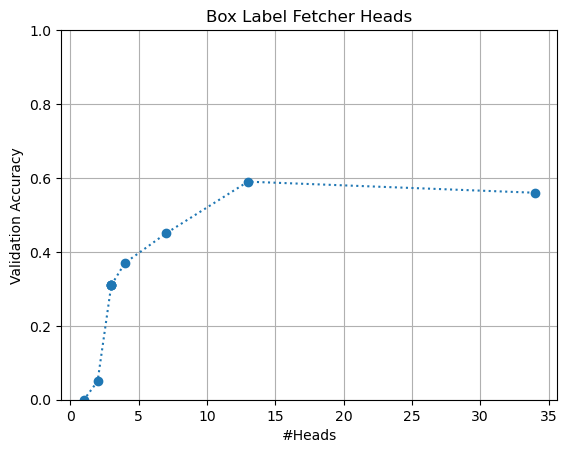

In [146]:
# Plot valid_acc vs num_heads

plt.plot(num_heads, valid_acc, "o:")
plt.xlabel("#Heads")
plt.ylabel("Validation Accuracy")
plt.title("Box Label Fetcher Heads")
plt.ylim(0, 1)
plt.grid()

plt.show()

## Comparison with Path Patching

In [134]:
mask_path = './masks/forward/last_pos/object_value_fetcher/'
masks = sorted([float(mask) for mask in os.listdir(mask_path) if '.png' not in mask])

pp_path = "./new_pp_exps/forward/direct_logit_heads.pt"
logit_values = torch.load(pp_path)

precision = []
num_heads = []
for lamb in masks:
    mask = torch.load(f"{path}/{lamb}")
    rounded = torch.round(mask.data)
    masked_heads = compute_heads_from_mask(rounded)
    masked_heads = [(l, h) for l, h in masked_heads]
    pp_heads = direct_logit_heads = analysis_utils.compute_topk_components(
        logit_values, k=len(masked_heads), largest=False
    )
    pp_heads = [(l, h) for l, h in pp_heads]
    # Compute precision and recall between masked_heads and pp_heads without scikit-learn
    precision.append(round(len(set(masked_heads).intersection(set(pp_heads))) / len(pp_heads), 2))
    num_heads.append(len(masked_heads))

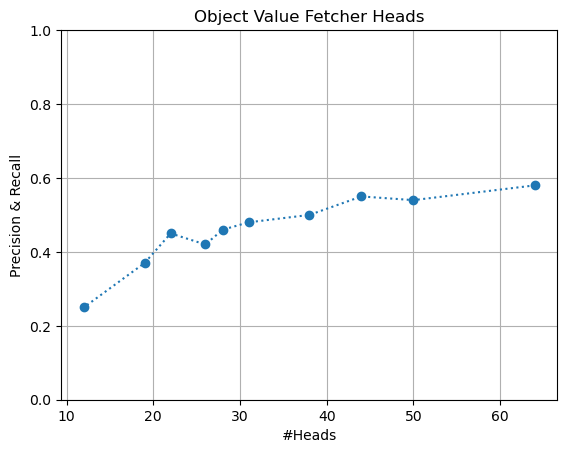

In [136]:
# Plot precision vs num_heads
plt.plot(num_heads, precision, "o:")
plt.xlabel("#Heads")
plt.ylabel("Precision & Recall")
plt.title("Object Value Fetcher Heads")
plt.ylim(0, 1)
plt.grid()
plt.show()